Machine Learning Med Devices
Jiaoli Yang

 ### Hackathon

Use the following dataset to train and test deep-learning CNN model to identify if a given image represents tumor in brain or not.

In [ ]:
import os
import numpy as np
import seaborn as sns
from random import choices

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets,layers,models
import cv2
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization,Input,ZeroPadding2D,Activation
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model,load_model
import matplotlib.pyplot as plt

## 1.Unzip brain_tumor_dataset

In [ ]:
!ls '/content/drive/MyDrive/INFO 7374/Exercise/brain_tumor_dataset.zip'
!unzip '/content/drive/MyDrive/INFO 7374/Exercise/brain_tumor_dataset.zip'
!pwdy

'/content/drive/MyDrive/INFO 7374/Exercise/brain_tumor_dataset.zip'
Archive:  /content/drive/MyDrive/INFO 7374/Exercise/brain_tumor_dataset.zip
replace __MACOSX/._brain_tumor_dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._brain_tumor_dataset  
  inflating: brain_tumor_dataset/.DS_Store  
  inflating: __MACOSX/brain_tumor_dataset/._.DS_Store  
  inflating: __MACOSX/brain_tumor_dataset/._no  
  inflating: __MACOSX/brain_tumor_dataset/._yes  
  inflating: brain_tumor_dataset/no/30 no.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._30 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._22 no.jpg  
  inflating: brain_tumor_dataset/no/41 no.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._41 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._14 no.jpg  
  inflating: brain_tumor_dataset/no/no 10.jpg  
  inflating: __MACOSX/brain_tumor_dataset/no/._no 10.j

In [ ]:
!ls /content/brain_tumor_dataset/

no  yes


In [ ]:
#!rm -rf brain_tumor_dataset

In [ ]:
# # Alternative method to unzip
# local_zip = '/content/tmp/brain_tumor_dataset.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

# print(len(os.listdir('/content/brain_tumor_dataset/yes/')))
# print(len(os.listdir('/content/brain_tumor_dataset/no/')))

 ## 2.Randomly Select 5 Images from all images

2.1 Combine all images and randomly select 5 images

In [ ]:
import os, random, shutil
SOURCE_DIR = "/content/brain_tumor_dataset/"
ALLFILE_DIR =  "/content/brain_tumor_dataset/all_image"
CATEGORY = ['yes','no']

try:
    os.mkdir(ALLFILE_DIR)
except OSError:
        pass

for category in CATEGORY:
    FileNames = os.listdir(SOURCE_DIR +category)
    print(category + ": " +  str(len(FileNames)))
    FileNames = os.listdir(SOURCE_DIR + category)
    for name in FileNames:
        shutil.copy(os.path.join(SOURCE_DIR + category, name), os.path.join(ALLFILE_DIR, name))


all_file = os.listdir(ALLFILE_DIR)
sample = random.sample(all_file, 5)
print("***********************************")
print('Total images: ', len(all_file))
print('Select images: ', len(sample))
print(sample)
#print('Remaining images for split: ', len(all_file) - len(test_sample))

for category in CATEGORY:
    FileNames = os.listdir(SOURCE_DIR +category)
    print(category + ": " +  str(len(FileNames)))
    
print("***********************************")

yes: 155
no: 98
***********************************
Total images:  253
Select images:  5
['19 no.jpg', '31 no.jpg', 'Y250.jpg', '33 no.jpg', 'Y161.JPG']
yes: 155
no: 98
***********************************


2.2 Copy sample data to sample file and remove them from original file)

In [ ]:
#rm -rf '/content/brain_tumor_dataset/'
SAMPLE_DIR = "/content/brain_tumor_dataset/sample"
try:
    os.mkdir(SAMPLE_DIR)
except OSError:
        pass

for tmp_sample in sample:
    for category in CATEGORY:
        if(tmp_sample) in  os.listdir(os.path.join(SOURCE_DIR,category)):
            print("This sample image: " + tmp_sample +  " , original files is : " + category)
            shutil.move(os.path.join(SOURCE_DIR,category,tmp_sample),os.path.join(SAMPLE_DIR,tmp_sample))

print("*********After removing sample data****************")
for category in CATEGORY:
    dir = os.path.join(SOURCE_DIR,category)
    print("Current file" ,category,':',len(os.listdir(dir)))


print("***********************************")

*********After removing sample data****************
Current file yes : 153
Current file no : 95
***********************************


## 3. Spilt training data and validation data

In [ ]:
def split_data(SOURCE, CATEGORY, SPLIT_SIZE):
    import numpy as np
    import shutil

    allFileNames = os.listdir(SOURCE + CATEGORY)
    #print(allFileNames)

    for file in allFileNames:
      if os.stat(os.path.join(SOURCE + CATEGORY, file)).st_size == 0:
        print ("Empty file found: " + file)
        allFileNames.remove(file)

    for file in allFileNames:
      img = cv2.imread(os.path.join(SOURCE + CATEGORY, file))
      #print(img.shape)

    # Use os.mkdir to create your directories
    # You will need a subdirectories for training
    # and testing. These in turn will need subdirectories for 'yes' and 'no'
    train_dir = os.path.join(SOURCE, 'train')
    test_dir = os.path.join(SOURCE, 'test')
    train_dir_for_category = os.path.join(train_dir, CATEGORY)
    test_dir_for_category = os.path.join(test_dir, CATEGORY)
    print('Train_dir : '+ train_dir)
    print('Test_dir' + test_dir)
    print('Train_dir_for_category' + train_dir_for_category)
    print('Test_dir_for_category' + test_dir_for_category)
    try:
      os.mkdir(train_dir)
      os.mkdir(test_dir)
    except OSError:
        pass

    train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (SPLIT_SIZE))])

    print("*****************************")
    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))
    print("*****************************")
    
    # Create destination directories
    try:
      os.mkdir(train_dir_for_category)
      os.mkdir(test_dir_for_category)
    except OSError:
        pass
    
    # Ensure there are no stale files in destination directories
    for file in os.scandir(train_dir_for_category):
        os.remove(file.path)
        
    for file in os.scandir(test_dir_for_category):
        os.remove(file.path)
        
    print(len(os.listdir(train_dir_for_category)))
    print(len(os.listdir(test_dir_for_category)))
    
    for name in train_FileNames:
      #print(name)
      #print(os.path.join(SOURCE + CATEGORY, name))
      #print(os.path.join(train_dir_for_category, name))
      shutil.copy(os.path.join(SOURCE + CATEGORY, name), os.path.join(train_dir_for_category, name))

    for name in test_FileNames:
        dest = shutil.copy(os.path.join(SOURCE + CATEGORY, name), os.path.join(test_dir_for_category, name))
    print("Copying Done!")

    # Optionally remove original files
    for file in os.scandir(SOURCE + CATEGORY):
        os.remove(file.path)
    os.removedirs(SOURCE + CATEGORY)

SOURCE_DIR = "/content/brain_tumor_dataset/"
YES_SUB_DIR = "yes"
NO_SUB_DIR = "no"
CATEGORIES = [NO_SUB_DIR,YES_SUB_DIR]
train_dir = os.path.join(SOURCE_DIR, 'train')
test_dir = os.path.join(SOURCE_DIR, 'test')

split_size = .9 # 90% training, 10% test
split_data(SOURCE_DIR, YES_SUB_DIR, split_size)
split_data(SOURCE_DIR, NO_SUB_DIR, split_size)

Train_dir : /content/brain_tumor_dataset/train
Test_dir/content/brain_tumor_dataset/test
Train_dir_for_category/content/brain_tumor_dataset/train/yes
Test_dir_for_category/content/brain_tumor_dataset/test/yes
*****************************
Total images:  153
Training:  137
Testing:  16
*****************************
0
0
Copying Done!
Train_dir : /content/brain_tumor_dataset/train
Test_dir/content/brain_tumor_dataset/test
Train_dir_for_category/content/brain_tumor_dataset/train/no
Test_dir_for_category/content/brain_tumor_dataset/test/no
*****************************
Total images:  95
Training:  85
Testing:  10
*****************************
0
0
Copying Done!


## 4.Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=25,
      width_shift_range=0.05,
      height_shift_range=0.05,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip = True,
      brightness_range=[0.3, 1.5],
      fill_mode='nearest')

heights = []
widths = []
for category in CATEGORIES:
  for file in os.listdir(os.path.join(os.path.join(SOURCE_DIR, 'train'), category)):
    img = cv2.imread(os.path.join(os.path.join(os.path.join(SOURCE_DIR, 'train'), category), file))
    h, w, c = img.shape
    heights.append(int(h))
    widths.append(int(w))

print(min(heights))
print(min(widths))

test_heights = []
test_widths = []
for category in CATEGORIES:
  for file in os.listdir(os.path.join(os.path.join(SOURCE_DIR, 'test'), category)):
    img = cv2.imread(os.path.join(os.path.join(os.path.join(SOURCE_DIR, 'test'), category), file))
    h, w, c = img.shape
    test_heights.append(int(h))
    test_widths.append(int(w))
   
print(min(test_heights))
print(min(test_widths))

min_height = min(min(heights), min(test_heights))
min_width = min(min(widths), min(test_widths))
target = min(min_height, min_width)
print('target size(min):',target)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='binary', 
    target_size=(target, target))

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(target, target))

168
150
223
196
target size(min): 150
Found 222 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


USE VGG16

In [ ]:
from keras.applications import VGG16

VGG_model = VGG16(weights = 'imagenet',
                   include_top = False,
                   input_shape = (target,target,3))

## 5 Build a model without Dropout and Hyperparameter tunning


In [ ]:
model_withoutDropout = tf.keras.Sequential()
model_withoutDropout.add(VGG_model)
model_withoutDropout.add(layers.Flatten())
model_withoutDropout.add(Dense(128, activation = 'relu'),)
model_withoutDropout.add(Dense(64, activation = 'relu'))
model_withoutDropout.add(BatchNormalization())
model_withoutDropout.add(Dense(1, activation = 'sigmoid'))

model_withoutDropout.layers[0].trainable = False

model_withoutDropout.compile(
    loss='binary_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

model_withoutDropout.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 15,771,969
Trainable params: 1,057,153
Non-trainable params: 14,714,816
____________________________________

In [ ]:
history_withoutDropout = model_withoutDropout.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=20
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
12/12 [==============================] - 57s 5s/step - loss: 0.6761 - accuracy: 0.6771 - val_loss: 0.8506 - val_accuracy: 0.6538
Epoch 2/20
12/12 [==============================] - 55s 5s/step - loss: 0.4307 - accuracy: 0.7990 - val_loss: 0.7364 - val_accuracy: 0.6538
Epoch 3/20
12/12 [==============================] - 55s 5s/step - loss: 0.3901 - accuracy: 0.8025 - val_loss: 0.4048 - val_accuracy: 0.7692
Epoch 4/20
12/12 [==============================] - 55s 5s/step - loss: 0.4887 - accuracy: 0.7533 - val_loss: 0.7986 - val_accuracy: 0.6923
Epoch 5/20
12/12 [==============================] - 55s 5s/step - loss: 0.3723 - accuracy: 0.8720 - val_loss: 0.4662 - val_accuracy: 0.7308
Epoch 6/20
12/12 [==============================] - 55s 5s/step - loss: 0.3308 - accuracy: 0.8668 - val_loss: 0.3571 - val_accuracy: 0.8846
Epoch 7/20
12/12 [==============================] - 55s 5s/step - loss: 0.3855 - accuracy: 0.7893 - val_loss: 0.3189 - val_accuracy: 0.8846
Epoch 8/20
12/12 [==

In [ ]:
def plot_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

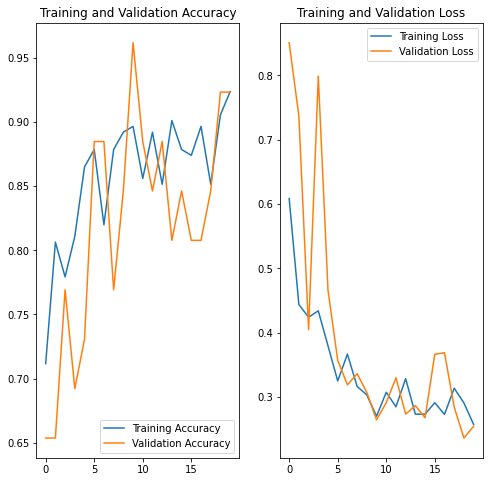

In [ ]:
plot_accuracy(history_withoutDropout)

As we can see, the validation accurary has a great fluctuation which means our model is overfitting.

Model 3 with dropout

In [ ]:
model_dropout = tf.keras.Sequential()
model_dropout.add(VGG_model)
model_dropout.add(layers.Flatten())
model_dropout.add(Dropout(0.4))
model_dropout.add(Dense(128, activation = 'relu'),)
model_dropout.add(Dense(64, activation = 'relu'))
model_dropout.add(Dropout(0.3))
model_dropout.add(BatchNormalization())
model_dropout.add(Dense(1, activation = 'sigmoid'))

model_dropout.layers[0].trainable = False

model_dropout.compile(
    loss='binary_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)               

In [ ]:
history_dropout = model_dropout.fit(
      train_generator,
      epochs=20,
      validation_data=validation_generator,
      )

Epoch 1/20
12/12 [==============================] - 57s 5s/step - loss: 0.7416 - accuracy: 0.6209 - val_loss: 0.7639 - val_accuracy: 0.6923
Epoch 2/20
12/12 [==============================] - 55s 5s/step - loss: 0.5826 - accuracy: 0.7248 - val_loss: 1.2329 - val_accuracy: 0.6154
Epoch 3/20
12/12 [==============================] - 55s 5s/step - loss: 0.5924 - accuracy: 0.7066 - val_loss: 1.3122 - val_accuracy: 0.6154
Epoch 4/20
12/12 [==============================] - 55s 5s/step - loss: 0.5061 - accuracy: 0.7730 - val_loss: 0.7966 - val_accuracy: 0.6923
Epoch 5/20
12/12 [==============================] - 55s 5s/step - loss: 0.5444 - accuracy: 0.7251 - val_loss: 0.5801 - val_accuracy: 0.6538
Epoch 6/20
12/12 [==============================] - 55s 5s/step - loss: 0.5116 - accuracy: 0.7747 - val_loss: 0.4095 - val_accuracy: 0.8077
Epoch 7/20
12/12 [==============================] - 55s 5s/step - loss: 0.4260 - accuracy: 0.8048 - val_loss: 0.3904 - val_accuracy: 0.8077
Epoch 8/20
12/12 [==

Plot Accuracy

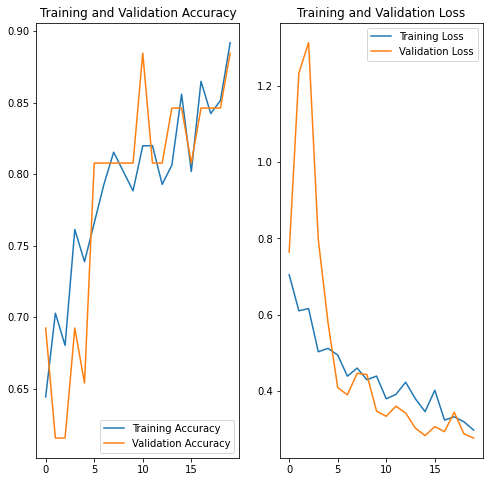

In [ ]:
plot_accuracy(history_dropout)

As we can see, after we added two dropout layers, the validation accuracy become better.

Model With Hyperparameter tunning

In [ ]:
pip install keras-tuner

In [ ]:
from kerastuner import HyperModel

In [ ]:
class HyperModel(HyperModel):
    def __init__(self,input_shape,num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self,hp):
        model_hyper = keras.Sequential()
        model_hyper.add(Conv2D(
           filters=hp.Choice(
                'num_filters',
                values=[32,64,128,256],
                default=64,
            ),
            padding = 'same',
            activation='relu',
            kernel_size=3))

        model_hyper.add(MaxPooling2D(2,2))
        model_hyper.add(BatchNormalization())
        model_hyper.add(Conv2D(
           filters=hp.Choice(
                'num_filters',
                values=[32,64,128,256],
                default=64,
            ),
            padding = 'same',
            activation='relu',
            kernel_size=3))

        model_hyper.add(layers.Flatten())
        model_hyper.add(
            Dropout(rate = hp.Float(
                'dropout',
                min_value = 0,
                max_value = 0.5,
                default = 0.25,
                step = 0.05
            ))
        )
        model_hyper.add(
                Dense(
                    units = hp.Int(
                        'units',
                        min_value = 64,
                        max_value = 512,
                        step = 32,
                        default = 256
                    ),
                    activation = hp.Choice(
                        'dense_activation',
                        values = ['relu','sigmoid'],
                        default = 'relu'
                    )
                )
            )

        model_hyper.add(Dense(64,activation = 'relu'))
        model_hyper.add(layers.Dense(1,activation = 'sigmoid'))

        model_hyper.compile(
            loss = 'binary_crossentropy',
            optimizer = keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value = 1e-4,
                    max_value = 1e-2,
                    sampling = 'LOG',
                    default = 1e-3
                )
            ),
            metrics = ['accuracy']
        )

        return model_hyper

In [ ]:
from kerastuner.tuners import RandomSearch

NUM_CLASSES = 2
INPUT_SHAPE = (target,target,3)
HYPERBAND_MAX_EPOCHS = 20
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2
SEED = 1

hyper_model = HyperModel(input_shape= INPUT_SHAPE, num_classes= NUM_CLASSES)

hyper_tunner = RandomSearch(
    hyper_model,
    objective = 'val_accuracy',
    seed = SEED,
    max_trials = MAX_TRIALS,
    executions_per_trial = EXECUTION_PER_TRIAL,
    directory = 'random_search',
    project_name = 'brain_tunmor_hyper2'
)

hyper_tunner.search_space_summary()

Search space summary
Default search space size: 5
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units (Int)
{'default': 256, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
hyper_tunner.search(train_generator,
                    validation_data = validation_generator, 
                    epochs = 30)

Trial 12 Complete [00h 13m 22s]
val_accuracy: 0.7692307829856873

Best val_accuracy So Far: 0.8076923191547394
Total elapsed time: 08h 19m 53s

Search: Running Trial #13

Hyperparameter    |Value             |Best Value So Far 
num_filters       |256               |64                
dropout           |0.45              |0.5               
units             |256               |352               
dense_activation  |sigmoid           |relu              
learning_rate     |0.00067529        |0.00015159        

Epoch 1/30
12/12 [==============================] - 144s 12s/step - loss: 0.7413 - accuracy: 0.6075 - val_loss: 0.6901 - val_accuracy: 0.6154
Epoch 2/30
12/12 [==============================] - 139s 12s/step - loss: 0.6481 - accuracy: 0.6489 - val_loss: 0.7166 - val_accuracy: 0.6154
Epoch 3/30
12/12 [==============================] - 138s 11s/step - loss: 0.6257 - accuracy: 0.6541 - val_loss: 0.6878 - val_accuracy: 0.6154
Epoch 4/30
12/12 [==============================] - 138s 12s

In [ ]:
hyper_tunner.results_summary()
best_model = hyper_tunner.get_best_models(num_models = 1)[0]

Results summary
Results in random_search/brain_tunmor_hyper
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_filters: 32
dropout: 0.30000000000000004
units: 128
dense_activation: relu
learning_rate: 0.0011971901340926848
Score: 0.7884615361690521
Trial summary
Hyperparameters:
num_filters: 64
dropout: 0.05
units: 192
dense_activation: relu
learning_rate: 0.000797425773423712
Score: 0.7692307829856873
Trial summary
Hyperparameters:
num_filters: 32
dropout: 0.05
units: 384
dense_activation: relu
learning_rate: 0.006599917029213527
Score: 0.7692307531833649
Trial summary
Hyperparameters:
num_filters: 32
dropout: 0.2
units: 480
dense_activation: relu
learning_rate: 0.0033137745378583987
Score: 0.7692307531833649
Trial summary
Hyperparameters:
num_filters: 32
dropout: 0.2
units: 320
dense_activation: relu
learning_rate: 0.0009887195863122636
Score: 0.75
Trial summary
Hyperparameters:
num_filters: 64
dropout: 0.25
units: 192
dense_acti

In [ ]:
history_best_model = best_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30)

Epoch 1/30
12/12 [==============================] - 8s 591ms/step - loss: 0.4890 - accuracy: 0.8023 - val_loss: 0.5444 - val_accuracy: 0.6923
Epoch 2/30
12/12 [==============================] - 7s 555ms/step - loss: 0.5375 - accuracy: 0.7099 - val_loss: 0.5093 - val_accuracy: 0.7308
Epoch 3/30
12/12 [==============================] - 7s 552ms/step - loss: 0.5031 - accuracy: 0.7702 - val_loss: 0.5124 - val_accuracy: 0.6923
Epoch 4/30
12/12 [==============================] - 7s 558ms/step - loss: 0.4862 - accuracy: 0.7633 - val_loss: 0.5058 - val_accuracy: 0.7308
Epoch 5/30
12/12 [==============================] - 7s 555ms/step - loss: 0.4427 - accuracy: 0.8205 - val_loss: 0.6249 - val_accuracy: 0.7308
Epoch 6/30
12/12 [==============================] - 7s 550ms/step - loss: 0.5464 - accuracy: 0.7541 - val_loss: 0.5113 - val_accuracy: 0.6538
Epoch 7/30
12/12 [==============================] - 7s 572ms/step - loss: 0.6109 - accuracy: 0.7018 - val_loss: 0.5111 - val_accuracy: 0.7308
Epoch 

Plot data

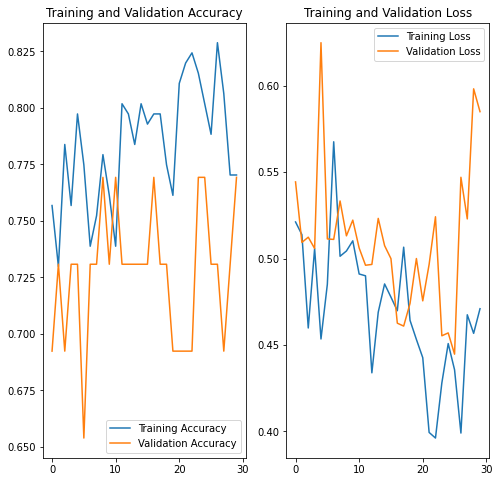

In [ ]:
plot_accuracy(history_best_model)

Predict sample data

In [ ]:
# Predict using Test Data

for file in os.listdir(os.path.join(SAMPLE_DIR)):
    print("Sample Image: ",file)
    img = keras.preprocessing.image.load_img(
    os.path.join(os.path.join(SAMPLE_DIR, file)), 
                target_size=(target, target))

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = best_model.predict(img_array)
    score = tf.nn.sigmoid(predictions[0])
    
    print("The predicaiton result : " ,predictions[0][0])
    print(100* score)
    print()

Sample Image:  Y53.jpg
The predicaiton result :  1.0
tf.Tensor([73.10586], shape=(1,), dtype=float32)

Sample Image:  Y61.jpg
The predicaiton result :  1.2647157e-09
tf.Tensor([50.], shape=(1,), dtype=float32)

Sample Image:  Y55.jpg
The predicaiton result :  1.0
tf.Tensor([73.10586], shape=(1,), dtype=float32)

Sample Image:  38 no.jpg
The predicaiton result :  0.0
tf.Tensor([50.], shape=(1,), dtype=float32)

Sample Image:  11 no.jpg
The predicaiton result :  0.0
tf.Tensor([50.], shape=(1,), dtype=float32)

